In [1]:
# Params
input_size = (1200,800)
batch_size = 8
num_workers = 8
num_classes = 2
learning_rate = 1e-03
epochs = 100

In [2]:
import torch

print("torch-version:", torch.__version__)
print("Available GPU:", torch.cuda.current_device())

torch-version: 1.1.0
Available GPU: 0


In [3]:
from load_MH import *

# 기존 데이터 경로
NORMAL_DIR = '../../snapshots_pureok'
FAULT_DIR = '../../snapshots'
# 추가 데이터 경로
ADD_NORMAL_DIR = '../../snapshots_punch181'
ADD_FAULT_DIR = '../../snapshots_punch181_NG'

train_mhdb = dataset(NORMAL_DIR, FAULT_DIR, ADD_NORMAL_DIR, ADD_FAULT_DIR, input_size, batch_size, num_workers)[:4]
val_mhdb = dataset(NORMAL_DIR, FAULT_DIR, ADD_NORMAL_DIR, ADD_FAULT_DIR, input_size, batch_size, num_workers)[4:8]
test_mhdb = dataset(NORMAL_DIR, FAULT_DIR, ADD_NORMAL_DIR, ADD_FAULT_DIR, input_size, batch_size, num_workers)[8:]

In [4]:
from googlenet_pytorch import *
    
net = googlenet(pretrained=False, progress=True, num_classes=num_classes, aux_logits=True, transform_input=False, init_weights=True).cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [5]:
def validation(dataset, model, criterion):
    
    with torch.no_grad():
        model.eval()
        running_loss = 0.0
        for data in dataset:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda().long()

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            
    return running_loss

In [6]:
import numpy as np

times = 1
aux_loss_weight = 0.3
all_train_loss = []
all_val_loss = []
row = np.arange(epochs)

for epoch in range(epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_mhdb[0]):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda().long()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, aux_2, aux_1 = net(inputs) #tuple: (x, aux2, aux1)
                
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_2, labels)
        loss3 = criterion(aux_1, labels)
        
        loss = loss1 + aux_loss_weight*loss2 + aux_loss_weight*loss3
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if epoch % times == 0:
        print("Epoch:", epoch)
        print("Train Loss:", running_loss / times)
        val_loss = validation(val_mhdb[0], net, criterion)
        print("Val Loss:", val_loss)
        
        name = "CAM1"+"-Epoch-"+"%s"%epoch+"-Loss-"+"%s"%str(val_loss)[:8]+".pth"
        model_path = './saved_models/' + name
        torch.save(net.state_dict(), model_path)
        print("Saved model:", model_path, "\n")
        
        all_train_loss.append(running_loss)
        all_val_loss.append(val_loss)
        running_loss = 0.0

print('\nFinished Training')

Epoch: 0
Train Loss: 351.7522031068802
Val Loss: 33.96664410829544
Saved model: ./saved_models/CAM1-Epoch-0-Loss-33.96664.pth 

Epoch: 1
Train Loss: 339.503602206707
Val Loss: 49.94633310288191
Saved model: ./saved_models/CAM1-Epoch-1-Loss-49.94633.pth 

Epoch: 2
Train Loss: 342.01399594545364
Val Loss: 34.7032145857811
Saved model: ./saved_models/CAM1-Epoch-2-Loss-34.70321.pth 

Epoch: 3
Train Loss: 339.29276701807976
Val Loss: 53.26811748743057
Saved model: ./saved_models/CAM1-Epoch-3-Loss-53.26811.pth 

Epoch: 4
Train Loss: 331.0422160625458
Val Loss: 34.77732050418854
Saved model: ./saved_models/CAM1-Epoch-4-Loss-34.77732.pth 

Epoch: 5
Train Loss: 331.0733320116997
Val Loss: 34.48135790228844
Saved model: ./saved_models/CAM1-Epoch-5-Loss-34.48135.pth 

Epoch: 6
Train Loss: 331.2131323814392
Val Loss: 36.37122693657875
Saved model: ./saved_models/CAM1-Epoch-6-Loss-36.37122.pth 

Epoch: 7
Train Loss: 332.2424096465111
Val Loss: 34.06716725230217
Saved model: ./saved_models/CAM1-Epoc

Epoch: 63
Train Loss: 118.02446401119232
Val Loss: 17.557536110281944
Saved model: ./saved_models/CAM1-Epoch-63-Loss-17.55753.pth 

Epoch: 64
Train Loss: 120.78785695321858
Val Loss: 17.193133480846882
Saved model: ./saved_models/CAM1-Epoch-64-Loss-17.19313.pth 

Epoch: 65
Train Loss: 119.34449458122253
Val Loss: 25.296438977122307
Saved model: ./saved_models/CAM1-Epoch-65-Loss-25.29643.pth 

Epoch: 66
Train Loss: 117.62010999768972
Val Loss: 16.768531180918217
Saved model: ./saved_models/CAM1-Epoch-66-Loss-16.76853.pth 

Epoch: 67
Train Loss: 113.57946872711182
Val Loss: 19.528686672449112
Saved model: ./saved_models/CAM1-Epoch-67-Loss-19.52868.pth 

Epoch: 68
Train Loss: 114.66904269531369
Val Loss: 16.73801776021719
Saved model: ./saved_models/CAM1-Epoch-68-Loss-16.73801.pth 

Epoch: 69
Train Loss: 116.41023165360093
Val Loss: 16.536384984850883
Saved model: ./saved_models/CAM1-Epoch-69-Loss-16.53638.pth 

Epoch: 70
Train Loss: 109.44545633718371
Val Loss: 19.815132707357407
Saved m

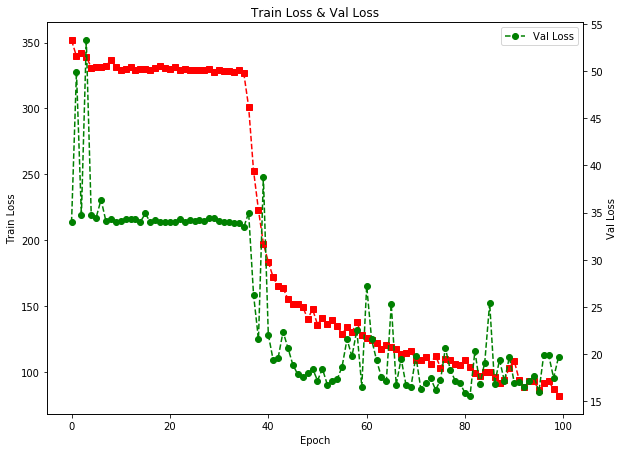

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax0 = plt.subplots(figsize=(9.6,7.2))
ax1 = ax0.twinx()
ax0.set_title("Train Loss & Val Loss")
ax0.plot(all_train_loss, 'rs--', label="Train Loss")
ax0.set_ylabel("Train Loss")
ax0.grid(False)
ax1.plot(all_val_loss, 'go--', label="Val Loss")
ax1.set_ylabel("Val Loss")
ax1.grid(False)
ax0.set_xlabel("Epoch")
plt.legend(loc=1)
plt.show()